<a href="https://colab.research.google.com/github/Kushagratandon12/Image_Caption_Generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/sample_data/
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import glob
import random
from numpy import array
from collections import OrderedDict
import pickle as pkl
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import seaborn as sns
import cv2
import os
from google.colab import drive
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
from google.colab import drive
drive.mount('/content/Mydrive',force_remount=True)

Mounted at /content/Mydrive


In [3]:
# %%capture
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip  '/content/flickr-image-dataset.zip' 
# # -d '/content/Mydrive/MyDrive/Image_Caption_Dataset'
# !rm -rf /content/flickr-image-dataset.zip

In [4]:
# # Images Present Inside The Dataset 
# images_data = glob.glob('/content/flickr30k_images/flickr30k_images/*.jpg')
# base_path = '/content/flickr30k_images/flickr30k_images/'
# print(images_data)
# random.shuffle(images_data)
# plt.figure(figsize=(13,13))
# for i in range(1,9):
#   plt.subplot(3,3,i)
#   img = plt.imread(images_data[i-1])
#   print(img.shape)
#   plt.imshow(img)

# gc.collect()

In [5]:
#Understanding The Text Data 
text_data = pd.read_csv('/content/Mydrive/MyDrive/Colab Notebooks/results.csv', sep='|')
text_data.columns = ['image', 'caption_number', 'caption']
text_data['caption'] = text_data['caption'].str.lstrip()
text_data['caption_number'] = text_data['caption_number'].str.lstrip()

#Cleaning A Filed Where Data Is Mis-managed
text_data.loc[19999, 'caption_number'] = "4"
text_data.loc[19999, 'caption'] = "A dog runs across the grass ."

#Providing Starting And Ending For Caption -> Help In Training
text_data['caption'] = "<start> "+text_data['caption']+" <end>"

ids = [id_ for id_ in range(len(text_data) // 5) for i in range(5)]
text_data['ids'] = ids
text_data.head(15)
# text_data['image'] = text_data.apply(lambda x : '/content/flickr30k_images/flickr30k_images/' + text_data['image'])

,image,caption_number,caption,ids
0,1000092795.jpg,0,<start> Two young guys with shaggy hair look a...,0
1,1000092795.jpg,1,"<start> Two young , White males are outside ne...",0
2,1000092795.jpg,2,<start> Two men in green shirts are standing i...,0
3,1000092795.jpg,3,<start> A man in a blue shirt standing in a ga...,0
4,1000092795.jpg,4,<start> Two friends enjoy time spent together ...,0
5,10002456.jpg,0,<start> Several men in hard hats are operating...,1
6,10002456.jpg,1,<start> Workers look down from up above on a p...,1
7,10002456.jpg,2,<start> Two men working on a machine wearing h...,1
8,10002456.jpg,3,<start> Four men on top of a tall structure . ...,1
9,10002456.jpg,4,<start> Three men on a large rig . <end>,1


In [6]:
(len(text_data)/5)*0.7

22248.1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


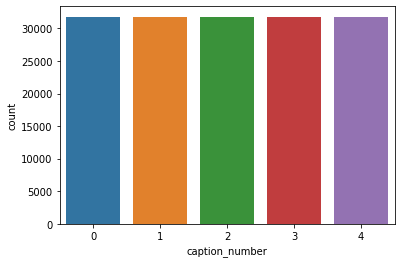

In [7]:
sns.countplot(text_data['caption_number'])

In [8]:
imgsfiles= text_data['image'].unique().tolist()
imgsids = text_data['ids'].unique().tolist()
print((imgsfiles))
print((imgsids))


['1000092795.jpg', '10002456.jpg', '1000268201.jpg', '1000344755.jpg', '1000366164.jpg', '1000523639.jpg', '1000919630.jpg', '10010052.jpg', '1001465944.jpg', '1001545525.jpg', '1001573224.jpg', '1001633352.jpg', '1001773457.jpg', '1001896054.jpg', '100197432.jpg', '100207720.jpg', '1002674143.jpg', '1003163366.jpg', '1003420127.jpg', '1003428081.jpg', '100444898.jpg', '1005216151.jpg', '100577935.jpg', '1006452823.jpg', '100652400.jpg', '1007129816.jpg', '100716317.jpg', '1007205537.jpg', '1007320043.jpg', '100759042.jpg', '10082347.jpg', '10082348.jpg', '100845130.jpg', '10090841.jpg', '1009434119.jpg', '1009692167.jpg', '101001624.jpg', '1010031975.jpg', '1010087179.jpg', '1010087623.jpg', '10101477.jpg', '1010470346.jpg', '1010673430.jpg', '101093029.jpg', '101093045.jpg', '1011572216.jpg', '1012150929.jpg', '1012212859.jpg', '1012328893.jpg', '101262930.jpg', '1013536888.jpg', '101362133.jpg', '101362650.jpg', '1014609273.jpg', '101471792.jpg', '1014785440.jpg', '1015118661.jpg', 

## Extract Features 
- CNN using VGG16
- inculde pen-ultimate layers 



In [9]:
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=(shape))
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray 
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [10]:
image_shape = (224,224)
feature_CNN = OrderedDict() #Features For CNN Network

base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True)

model = Model(inputs = base_model.inputs, outputs=base_model.layers[-2].output)
# model.summary()

# for ids , imgs in tqdm(zip(imgsids[:25486],imgsfiles[:25486])):
#   filename = os.path.join(base_path,imgs)
#   img = decode_img(filename,image_shape)
#   feat_extract = model.predict(img,verbose=0)
#   feature_CNN[ids]=feat_extract
# pkl.dump(feature_CNN,open('features.pkl','wb'))


## Load features - from pickle file 

In [11]:
data_selected_training = 8000

In [12]:
pickle_load = pkl.load(open('/content/Mydrive/MyDrive/Colab Notebooks/features.pkl','rb'))
features_CNN_images= OrderedDict()

for img_id in imgsids[:data_selected_training] :
    features_CNN_images[imgsfiles[img_id]]=pickle_load[img_id]

# pkl.dump(features_CNN_images,open('features_images.pkl','wb'))

In [13]:
imgfeat_captions = pkl.load(open('/content/Mydrive/MyDrive/Colab Notebooks/features_images.pkl','rb'))
for imgs in imgsfiles[:data_selected_training]:
    print(imgs,imgfeat_captions[imgs])
    break

1000092795.jpg [[0.        0.        1.1446092 ... 0.        0.        0.674052 ]]


In [14]:
text_data = text_data[:data_selected_training]
text_data.head()
dictionary = OrderedDict()
for ind in text_data.index:
  # print(text_data['image'][ind] , text_data['caption'][ind]) 
  if text_data['image'][ind] not in dictionary:
    dictionary[text_data['image'][ind]] = list()
  dictionary[text_data['image'][ind]].append(text_data['caption'][ind])

In [15]:
dictionary

OrderedDict([('1000092795.jpg',
              ['<start> Two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
               '<start> Two young , White males are outside near many bushes . <end>',
               '<start> Two men in green shirts are standing in a yard . <end>',
               '<start> A man in a blue shirt standing in a garden . <end>',
               '<start> Two friends enjoy time spent together . <end>']),
             ('10002456.jpg',
              ['<start> Several men in hard hats are operating a giant pulley system . <end>',
               '<start> Workers look down from up above on a piece of equipment . <end>',
               '<start> Two men working on a machine wearing hard hats . <end>',
               '<start> Four men on top of a tall structure . <end>',
               '<start> Three men on a large rig . <end>']),
             ('1000268201.jpg',
              ['<start> A child in a pink dress is climbing up a set of st

Cleaning The Captions

In [16]:
sentences = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

for image , caption in dictionary.items():
  for words in caption:
    sentences.append(words)
print(len((sentences)))

8000


In [17]:
vocab_size = 7817
embedding_dim = 16
max_length = 30
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8


tokenizer = Tokenizer(num_words=vocab_size , oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index =tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(sentences)
train_padded = pad_sequences(train_sequences , maxlen=max_length , padding='post')

In [18]:
print(len(word_index))
print(tokenizer)
print(sentences[np.random.randint(0,data_selected_training)])
print(train_sequences[np.random.randint(0,data_selected_training)])
print(train_padded[np.random.randint(0,data_selected_training)])

5114
<start> A young girl in a pink dress is petting a gray goat . <end>
[4, 45, 28, 9, 1695, 221, 11, 2, 861, 3]
[  4   2  13  19   2  32  20   9  63  12 795 104 139 386   3   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [19]:
gc.collect()

249

In [20]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [21]:
X1train, X2train, ytrain = create_sequences(tokenizer,max_length, dictionary, features_CNN_images, vocab_size)

In [22]:
print(type(X1train))

<class 'numpy.ndarray'>


In [23]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize model
	print(model.summary())
	return model

# define checkpoint callback
filepath = '/content/Mydrive/MyDrive/Colab Notebooks/Caption_Weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model = define_model(vocab_size, max_length)
history = model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      2001152     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________